### CHALLENGE_03

Linear Model: Fit a regression model (with an out-of-sample R42 of > 0.01) to a financial time series.
    
Financial series have a low signal-to-noise ratio, so even a weak correlation will require some basic feature engineering (moving average prices, volatility, etc).
    
What are some of the weaknesses of the model an how can it be improved with additional work?

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt



In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [3]:
# Load Dataset
tbills = pd.read_csv("data/T_bill.csv", parse_dates=["Issue Date"], index_col=0).sort_index(ascending=True)
tbills.sample(2)

,Issue No,Tenor,Weighted Average Rate
Issue Date,,,
2002-12-16,1543,182,8.722
2014-08-12,1988,364,10.285


In [4]:
# Check Date Range
str(tbills.index.min()), str(tbills.index.max())

('2001-01-01 00:00:00', '2017-12-25 00:00:00')

In [5]:
# Check Datatypes
tbills.dtypes

Issue No                   int64
Tenor                      int64
Weighted Average Rate    float64
dtype: object

In [6]:
# Check Missing Values
tbills.isna().sum()

Issue No                 0
Tenor                    0
Weighted Average Rate    0
dtype: int64

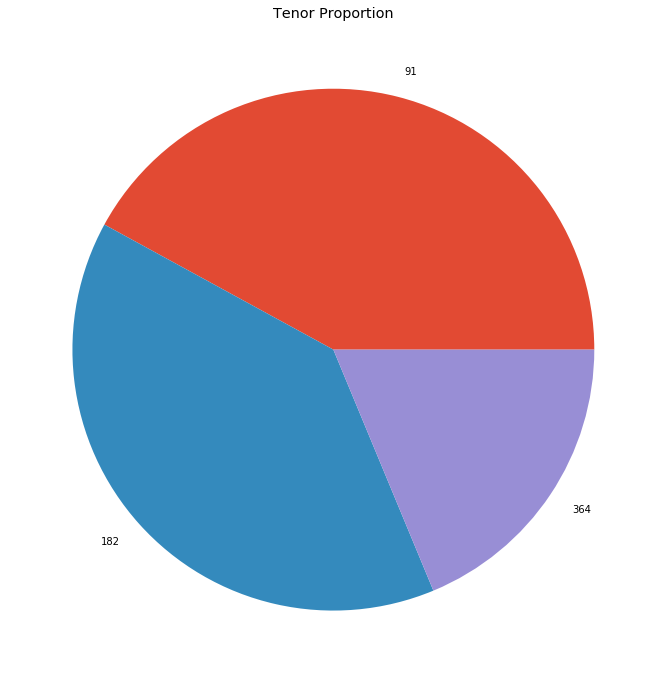

In [19]:
# Count of Records per Tenor
fig, ax = plt.subplots(figsize=(12, 12))
tbills["Tenor"].value_counts().plot(kind="pie", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Tenor Proportion")
plt.savefig("images/Tenor_Proportion.svg")

In [12]:
# Filter only 91-Day T-bills
tbills_91 = tbills[tbills["Tenor"]==91]
str(tbills_91.index.min()), str(tbills_91.index.max())

('2001-01-01 00:00:00', '2017-12-25 00:00:00')

In [21]:
tbills_91_weekly = tbills_91[["Weighted Average Rate"]].resample("W").mean()
tbills_91_weekly.sample()

,Weighted Average Rate
Issue Date,
2001-01-07,14.157
2001-01-14,11.981
2001-01-21,14.872
2001-01-28,14.987
2001-02-04,14.521
...,...
2017-12-03,8.011
2017-12-10,8.459
2017-12-17,NaN
